In [2]:
setwd('e:/thermokarst_gully/')
save.dir <- file.path(getwd(),"result")

In [3]:
# Averaging Approach
library(multifunc)

#for plotting
library(ggplot2)
library(patchwork)

#for data
library(tidyr)
library(dplyr)
library(purrr)
library(forcats)

#for analysis
library(car)
library(ggpubr)
library(ggpmisc)
library(vegan)
library(lme4)

Warning message:
"package 'tidyr' was built under R version 4.2.1"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'purrr' was built under R version 4.0.5"
Loading required package: carData

Warning message:
"package 'carData' was built under R version 4.0.5"

Attaching package: 'car'


The following object is masked from 'package:purrr':

    some


The following object is masked from 'package:dplyr':

    recode


Loading required package: ggpp


Attaching package: 'ggpp'


The following object is masked from 'package:ggplot2':

    annotate


Warning message:
"package 'vegan' was built under R version 4.0.5"
Loading required package: permute

Warning message:
"package 'permute' was built under R version 4.0.5"
Loading required package: lattice

Warning message:
"package 'lattice' was built under R version 4

In [10]:
#Read in data
div_table <- read.table(file = "E:/thermokarst_gully/data/multifun/multifun_richness_table_all.csv",
             sep = ',',  header = T, row.names = 1, stringsAsFactors = F)

allVars <- c("BG",  "NAG", "LAP", "PPO", "H2O2", "WHC", "SOC", "NO3_N", "NH4_N", "AGB", "plant_pathogen_control", "AP", "Soil_respiration")

# multi_func_df <- multi_func_df[, c("Plant_richness", "Soil_multidiv", "Ric_16s", "Ric_its", "Ric_pro", "Ric_anim", "Ric_N", "Ric_P", "Ric_S", "Ric_kegg", "Actinobacteria",	"Alphaproteobacteria",	"Acidobacteria",	"Firmicutes",	"Betaproteobacteria", "Planctomycetes",	"Gammaproteobacteria",	"Bacteroidetes",	"Deltaproteobacteria",	"Ascomycota",	"Basidiomycota",	"Mortierellomycota",	"Cercozoa",	"Conosa",	"Ciliophora",	"Chlorophyta",	"Apicomplexa",	"Ochrophyta",	"Pseudofungi",	"Lobosa",	"Sagenista",	"Opalozoa",	"Nematoda",	"Rotifera",	"Arthropoda",	"Annelida",	"Tardigrada", "Sample_name", "Gully_id", "Group", allVars)]

# varIdx<-which(names(all_biodepth) %in% allVars)

#add on the new functions along with the averaged multifunctional index
multi_ave_func_df <- cbind(div_table, getStdAndMeanFunctions(div_table, allVars, standardizeZScore))

`summarise()` has grouped output by 'Sample_name', 'Gully_id'. You can override
using the `.groups` argument.
Warning message in wilcox.test.default(c(7.86315789473684, 6.78947368421053, 5.70526315789474, :
"cannot compute exact p-value with ties"


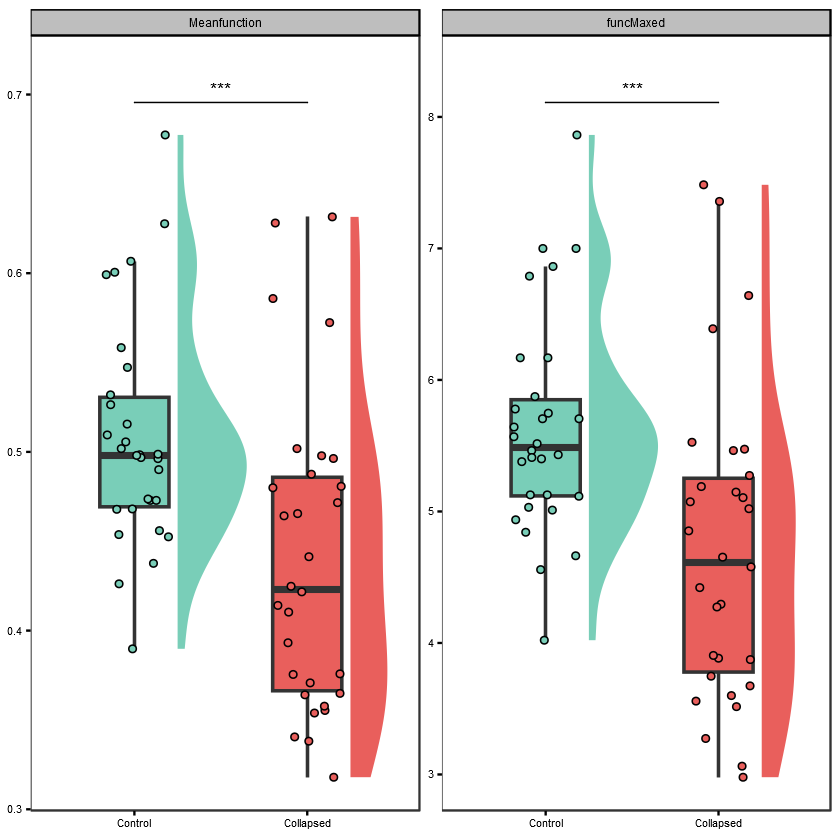

In [11]:
# Threshold Approach
thermoThresh <- getFuncsMaxed(div_table, allVars, threshmin = 0.05, threshmax = 0.99, 
                              threshstep = 0.01, prepend = c("plot","Diversity"), maxN = 13)

multifunctionality_tab <- thermoThresh %>%
  select(Sample_name, Gully_id, Group, funcMaxed) %>%
  group_by(Sample_name, Gully_id, Group) %>%
  dplyr::summarise(across(, mean, na.rm = TRUE)) %>%
  mutate(Group = factor(Group, levels = c("Control", "Collapsed"))) %>%
  data.frame(., Meanfunction = multi_ave_func_df$meanFunction)
# plot
library(gghalves)
main_theme = theme_bw() + 
  theme(panel.grid = element_blank(),
        panel.border = element_rect(size = 0.5),
        strip.text = element_text(colour = 'black', size = 7),
        strip.background = element_rect(colour = 'black', fill = 'grey'),
        axis.title = element_text(color = 'black',size = 7),
        axis.ticks = element_line(color = "black", linewidth = 0.5),
        axis.text.y = element_text(colour = 'black', size = 6),
        axis.text.x = element_text(colour = 'black', size = 6),
        legend.title = element_text(colour = 'black', size = 7),
        legend.text = element_text(colour = 'black', size = 6),
        legend.key.size = unit(0.5, 'cm'))
my_comparisons <- list(c('Control', 'Collapsed'))
p1 <- multifunctionality_tab %>%
  select(c("Group", "Meanfunction", "funcMaxed")) %>%
  pivot_longer(-c(Group), names_to = "Functionality", values_to = "value") %>%
  mutate(Group = factor(Group, levels = c("Control", "Collapsed"))) %>%
  mutate(Functionality = factor(Functionality, levels = c("Meanfunction", "funcMaxed"))) %>%
  ggplot(aes(Group, value, fill = Group)) +
  geom_half_violin(position = position_nudge(x = 0.25), side = "r", width = 0.8, color = NA) +
  geom_boxplot(width = 0.4, size = 0.75, outlier.color = NA) +
  geom_jitter(aes(fill = Group), shape = 21, size = 1.5, width = 0.2) +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.1))) +
  stat_compare_means(comparisons = my_comparisons, paired = F,
                     p.adjust.method = "BH", label = "p.signif", bracket.size = 0.3,
                     size = 3.5, tip.length = 0.00, method = "wilcox.test") +
  labs(x = NULL, y = NULL) +
  scale_fill_manual(values = c("#79ceb8", "#e95f5c", "#5cc3e8", "#ffdb00")) +
  facet_wrap(~Functionality, scales = "free_y", ncol = 4) +
  main_theme + theme(legend.position = "none")

save.dir.multifunc <- file.path(save.dir,"figs/multifunction")
if (!dir.exists(save.dir.multifunc)) {
  dir.create(save.dir.multifunc)
}
# ggsave(file.path(save.dir.multifunc, "./multifunctionality_comparison.pdf"),
#        p1, width = 3.5, height = 2.5, units = "in")
p1